# [파이썬 머신러닝 완벽 가이드] <br>
# 04 분류

## 04-6 XGBoost (eXtra Gradient Boost) <br>
### [XGBoost 개요]
- XGBoost는 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나임
- 분류에 있어서 일반적으로 다른 머신러닝보다 뛰어난 예측 성능을 나타냄
- XGBoost는 GBM에 기반하고 있지만, GBM의 단점인 느린 수행 시간 및 과적합 규제(REgularization) 부재 등의 문제를 해결해서 매우 각광을 받고 있음
- 병렬 CPU 환경에서 병렬 학습이 가능해 기존 GBM보다 빠르게 학습을 완료할 수 있음
- XGBoost의 주요 장점:
    - 뛰어난 예측 성능
    - GBM 대비 빠른 수행 시간
    - 과적합 규제 (Regularization)
    - Tree pruning (나무 가지치기)
    - 자체 내장된 교차 검증
    - 결손값 자체 처리

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

### [파이썬 래퍼 XGBoost 하이퍼 파라미터]
- 파이썬 래퍼 XGBoost 하이퍼 파라미터의 유형:
    - 일반 파라미터: 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
    - 부스터 파라미터: 트리 최적화, 부스팅, regularization 등과 관련 파라미터 등을 지칭함
    - 학습 태스크 파라미터: 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터임 <br><br>
    
#### 주요 일반 파라미터
- `booster`: gbtree(tree based model, default 옵션) 또는 gblinear(linear model) 선택
- `silent`: default는 0이며, 출력 메세지를 나타내고 싶지 않을 경우 1로 설정
- `nthread`: CPU의 실행 스레드 개수를 조정하며, default는 CPU의 전체 스레드를 다 사용함. 멀티 코어/스레드 CPU 시스템에서 전체 CPU를 사용하지 않고 일부 CPU만 사용해 ML 애플리케이션을 구동하는 경우에 변경함 <br><br>
    
#### 주요 부스터 파라미터
- `eta [default=0.3, alias: learning_rate]`: GBM의 학습률(learning rate)과 같은 파라미터. 0에서 1 사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값. 파이썬 래퍼 기반의 xgboost를 이용할 경우 default는 0.3이고 사이킷런 래퍼 클래스를 이용할 경우 eta는 learning_rate 파라미터로 대체되며, default는 0.1임. 보통은 0.01~0.2 사이의 값을 선호함
- `num_boost_rounds`: GBM의 n_estimators와 같은 파라미터
- `min_child_weight [default=1]`: 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합. min_child_weight이 클수록 분할을 자제하며 과적합을 조절하기 위해 사용됨
- `gamma [default=0, alias: min_split_loss]`: 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소 값으로 해당 값보다 큰 손실(loss)이 감소된 경우에 리프 노드를 분할함. 값이 클수록 과적합 감소 효과가 있음
- `max_depth [default=6]`: 트리 기반 알고리즘의 max_depth와 같으며 0을 지정하면 깊이에 제한이 없음. max_depth가 높으면 특정 피처 조건에 특화되어 룰 조건이 만들어지므로 과적합 가능성이 높아지며 보통은 3~10 사이의 값을 적용함
- `sub_sample [default=1]`: GBM의 subsample과 동일하며 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율을 지정함. sub_sample=0.5로 지정하면 전체 데이터의 절반을 트리를 생성하는 데 사용함. 0에서 1 사이의 값이 가능하나 일반적으로 0.5~1 사이의 값을 사용함
- `colsample_bytree [default=1]`: GBM의 max_features와 유사하며 tree 생성에 필요한 feature(column)를 임의로 샘플링 하는 데 사용됨. 매우 많은 feature가 있는 경우 과적합을 조정하는 데 적용함
- `lambda [default=1, alias:reg_lambda]` : L2 Regularization 적용 값으로 feature 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음
- `alpha` : L1 Regularization 적용값으로 feature 개수가 많을 경우 적용을 검토하며 값이 클수록 감소 효과가 있음
- `scale_pos_weight [default=1]` : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터 <br><br>
    
#### 학습 태스크 파라미터
- `objective` : 최솟값을 가져야할 손실 함수(loss function)을 정의하며 XGBoost는 많은 유형의 손실함수를 사용할 수 있음. 주로 사용되는 손실함수는 이진 분류인지 다중 분류인지에 따라 달라짐
    - `binary:logistic` : 이진 분류일 때 적용함
    - `multi:softmax` : 다중 분류일 때 적용하며 손실 함수가 multi:softmax일 경우에는 label class의 개수인 num_class parameter를 지정해야 함
    - `multi:softprob` : multi:softmax와 유사하나 개별 label class의 해당되는 예측 확률을 반환함
- `eval_metric` : 검증에 사용되는 함수를 정의하며 default는 회귀인 경우 rmse, 분류인 경우 error임.
    - `rmse` : Root Mean Square Error
    - `mae` : Mean Absolute Error
    - `logloss` : Negative log-likelihood
    - `error` : Binary classification error rate (0.5 threshold)
    - `merror` : Multiclass classification error rate
    - `mlogloss` : Multiclass logloss
    - `auc` : Area under the curve <br><br>

과적합 문제가 심각하다면 다음과 같이 적용함
- eta 값을 낮춤(0.01~0.1) eta 값을 낮출 경우 num_round (또는 n_estimators)는 반대로 높여줘야 함
- max_depth 값을 낮춤
- min_child_weight 값을 높임
- gamma 값을 높임
- subsample과 colsample_by_tree를 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 도움이 될 수 있음

In [2]:
import xgboost
print(xgboost.__version__)

1.5.0


### [파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측]
- 위스콘신 유방암 데이터 세트: 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성 종양(malignant)인지 양성 종양(benign)인지를 분류한 데이터 세트

In [5]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [6]:
#target: 0(malignant, 악성), 1(benign, 양성)
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [7]:
#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


- 파이썬 래퍼 XGBoost는 사이킷런과 다르게 학습용과 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix를 생성함 <br><br>
- DMatrix: 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트로 주요 입력 파라미터는 data와 label임
    - data: 피처 데이터 세트
    - label: 분류의 경우에는 레이블 데이터 세트, 회귀의 경우에 숫자형인 종속값 데이터 세트

In [8]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [21]:
params = {'max_depth':3, #트리 최대 깊이는 3
         'eta':0.1, #학습률 ta는 0.1
         'objective':'binary:logistic', #예제 데이터가 0 또는 1 이진분류이므로 목적함수는 이진 로지스틱
         'eval_metric':'logloss', # 오류 함수의 평가 성능 지표는 logloss
         'early_stoppings':100 #조기 중단할 수 있는 최소 반복 횟수를 100으로 설정
         }
num_rounds = 400  #num_rounds(부스팅 반복횟수)는 400회

- 조기 중단은 XGBoost가 수행 성능을 개선하기 위해 더 이상 지표 개선이 없을 경우에 num_boost_round 횟수를 모두 채우지 않고 중간에 반복을 빠져 나올 수 있도록 함 <br><br>
- `early_stopping_rounds` 파라미터를 설정해 조기 중단을 수행하기 위해서는 반드시 eval_set과 eval_metirc이 함꼐 설정되어야 함
    - `eval_set`: 성능 평가를 수행할 평가용 데이터 세트를 설정함
    - `eval_metric`: 평가 셍트에 적용할 성능 평가 방법으로 분류일 경우 주로 'error(분류 오류)', 'logloss'를 적용함

In [26]:
#train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기함
wlist = [(dtrain, 'train'), (dtest, 'eval')]
#하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[14:12:01] WARNING: ..\src\learner.cc:576: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0

[162]	train-logloss:0.00724	eval-logloss:0.08776
[163]	train-logloss:0.00722	eval-logloss:0.08778
[164]	train-logloss:0.00720	eval-logloss:0.08778
[165]	train-logloss:0.00718	eval-logloss:0.08752
[166]	train-logloss:0.00716	eval-logloss:0.08754
[167]	train-logloss:0.00714	eval-logloss:0.08764
[168]	train-logloss:0.00712	eval-logloss:0.08739
[169]	train-logloss:0.00710	eval-logloss:0.08738
[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08696
[177]	train-logloss:0.00696	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:

In [28]:
#사이킷런의 predict() 메소드가 예측 결과 클래스 값(0,1)을 반환하지만
#xgboost의 predict()는 예측 결과값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환함
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값ㅇ르 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정해 리스트 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결과값ㅇ르 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [32]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

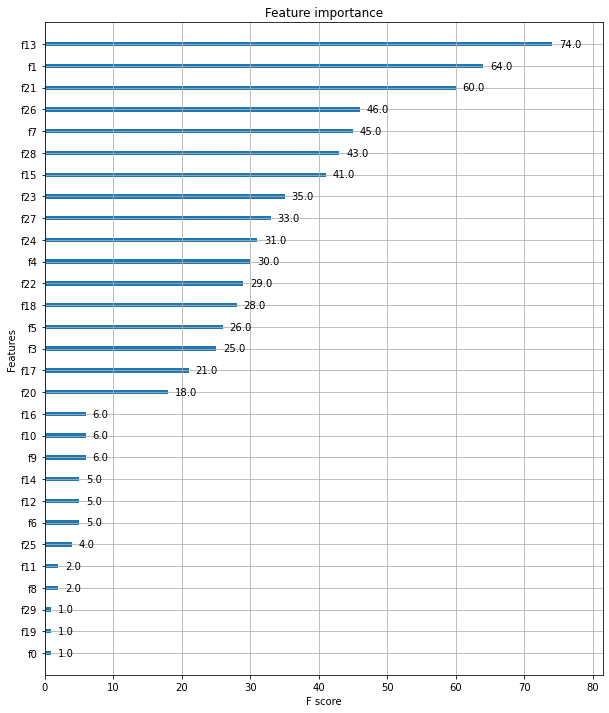

In [34]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

#xgboost 넘파이 기반의 피처 데이터로 학습 시에 피처명을 제대로 알 수가 없으므로 
#f0, f1와 같이 피처 순서별로 f자 뒤에 순서를 붙여서 X축에 피처들로 나열함

`xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)` <br>
→ DataFrame 형태로 반환
<br><br>
- `params (dict)`: 부스터 파라미터
- `dtrain (DMatrix)`: 학습 데이터
- `num_boost_round (int)`: 부스팅 반복 횟수
- `nfold (int)`: CV 폴드 개수
- `stratified (bool)`: CV 수행 시 층화 표본 추출 (stratified sampling) 수행 여부
- `metrics (string or list of strings)`: CV 수행 시 모니터링할 성능 평가 지표
- `early_stopping_rounds (int)`: 조기 중단을 활성화시킴. 반복 횟수 지정

### [사이킷런 래퍼 XGBoost의 개요 및 적용]
- 분류를 위한 래퍼 클래스: XGBClassifier
- 회귀를 위한 래퍼 클래스: XGBRegressor
<br><br>
- XGBClassifer은 기존 사이킷런에서 일반적으로 사용하는 하이퍼 파라미터와 호환성을 유지하기 위해 기존의 xgboost 모듈에서 사용하던 네이티브 하이퍼 파라미터를 다음과 같이 변경함
    - `eta` → `learning_rate`
    - `sub_sample` → `subsample`
    - `lambda` → `reg_lambda`
    - `alpha` → `reg_alpha` <br><br>
- xgboost의 `n_estimators`와 `num_boost_round` 하이퍼 파라미터는 서로 동일한 파라미터임
    - 두 개가 동시에 사용되면 파이썬 래퍼 XGBoost API에서는 n_estimators 파라미터를 무시하고 num_boost_round 파라미터를 적용함
    - XGBClassifier과 같은 사이킷런 래퍼 XGBoost 클래스에서는 n_estimators 파라미터를 적용함

In [35]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[14:48:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [37]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


In [38]:
#테스트 데이터 세트는 학습 시에는 완전히 알려지지 않은 데이터 세트를 사용해야 함
#평가에 테스트 데이터 세트를 사용하면 학습 시에 미리 참고가 되어 과적합할 수 있기 때문

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [39]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9954


In [41]:
#early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [42]:
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9947


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

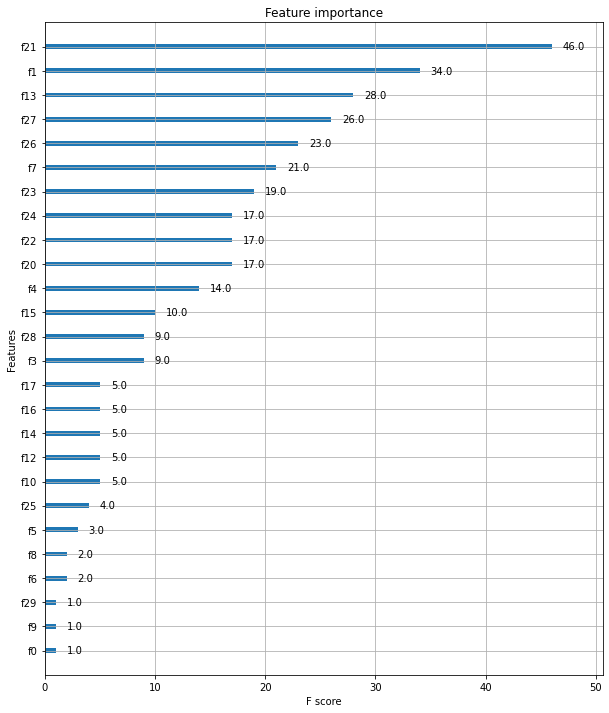

In [43]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
#사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

## 04-7 LightGBM <br>
- LightGBM은 XGBoost와 함께 부스팅 계열 알고리즘에서 가장 각광을 받고 있음
- 장점: XGBoost보다 학습에 걸리는 시간이 훨씬 적고 메모리 사용량도 상대적으로 적지만 예측 성능은 별 다른 차이가 없고 기능상의 다양성은 약간 더 많음
- 단점: 적은 데이터 세트(일반저긍로 10000건 이하)에 적용할 경우 과적합이 발생하기 쉬움
<br><br>
- LightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할 (Leaf Wise) 방식을 사용함
- 리프 중심 트리 분할 방식은 트리의 균형을 맞추지 않고, 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리를 생성함으로써 균형 트리 분할 방식 (Level Wise)보다 예측 오류 손실을 최소화함 <br>
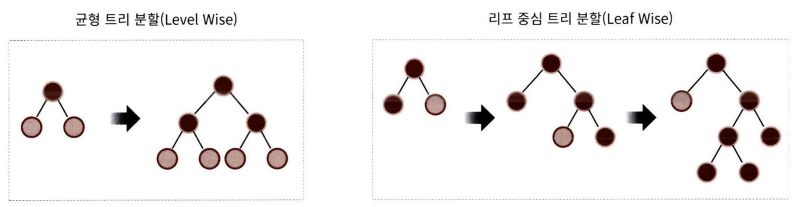
<br>
- LightGBm의 XGBoost 대비 장점
    - 더 빠른 학습과 예측 수행 시간
    - 더 작은 메모리 사용량
    - 카테고리형 피처의 자동 변환과 최적 분할 (원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

### [LightGBM 하이퍼 파라미터]
- LightGBM은 Xgboost와 다르게 리프 노드가 계속 분할되면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요함 <br><br>

#### 주요 파라미터
- `num_iterations [default=100]` : 반복 수행하려는 트리의 개수를 지정함. 크게 지정할수록 예측 성능이 높아질수 있으나, 너무 크게 지정하면 오히려 과적합으로 성능이 저하 될 수 있음. Scikit-Learn GBM과 XGBoost의 Scikit-Learn 호환 클래스의 n_estimators와 같은 파라미터이므로 LightGBM의 Scikit-Learn 호환 클래스에서는 n_estimators로 이름이 변경됨
- `learning_rate [default=0.1]` : 0에서 1사이의 값을 지정하며 Boosting 스텝을 반복적으로 수행할 때 업데이트되는 학습롤값임. 일반적으로 n_estimators를 크게하고 learning_rate를 작게해서 예측 성능을 향상시킬 수 있으나, 마찬가지로 과적합(overfitting) 이슈와 학습 시간이 길어지는 부정적인 영향도 고려해야함. GBM, XGBoost의 learning_rate와 같은 파라미터임
- `max_depth [default=-1]` : 트리 기반 알고리즘의 max_depth와 같으며 0보다 작은 값을 지정하면 깊이에 제한이 없음. 지금까지 소개한 Depth Wise 방식의 트리와 다르게 LightGBM은 Leaf wise 기반이므로 깊이가 상대적으로 더 깊음
- `min_data_in_leaf [default=20]` : Decision Tree의 min_samples_leaf와 같은 파라미터임. 하지만 Scikit-Learn 래퍼 LightGBM 클래스인 LightGBMClassifier에서는 min_child_samples 파라미터로 이름이 변경됨. 최종 결정 클래스인 Leaf 노드가 되기 위해서 최소한으로 필요한 레코드(데이터) 수이며, 과적합을 제어하기 위한 파라미터임
- `num_leaves [default=31]` : 하나의 트리가 가질 수 있는 최대 Leaf 개수임
- `boosting [default=gbdt]` : Boosting 트리를 생성하는 알고리즘을 기술함
    - `gbdt` : 일반적인 그레디언트 부스팅 결정트리
    - `rf` : 랜덤포레스트
- `bagging_fraction [default=1.0]` : 트리가 커져서 과적합되는 것을 제어하기 위해서 데이터 샘플링하는 비율을 지정함. Scikit-Learn의 GBM과 XGBoost의 sub_sample 파라미터와 동일하기에 Scikit-Learn 래퍼 LightGBM인 LightGBMClassifier에서는 sub_sample로 동일하게 파라미터 이름이 변경됨
- `feature_fraction [default=1.0]` : 개별 트리를 학습할 때마다 무작위로 선택하는 feature의 비율이며 과적합을 막기 위해 사용됨. GBM의 max_features와 유사하며, XGBClassifier의 colsample_bytree와 똑같으므로 LightGBMClassifier에서는 동일하게 colsample_bytree로 변경됨
- `lambda_l2 [default=0.0]` : L2 Regulation 제어를 위한 값으로 feature 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음. XGBClassifier의 reg_lambda와 동일하므로 LightGBMClassifier에서는 reg_lambda로 변경됨
- `lambda_l1 [default=0.0]` : L1 Regulation 제어를 위한 값으로 L2와 마찬가지로 과적합 제어를 위한 것이며, XGBClassifier의 reg_alpha와 동일하므로 LightGBMClassifier에서는 reg_alpha로 변경됨 <br><br>

#### Learning Task 파라미터
- `objective`: 최솟값을 가져야 할 손실함수를 정의하며 Xgboost의 objective 파라미터와 동일함. 애플리케이션 유형, 즉 회귀, 다중 클래스 분류, 이진 분류인지에 따라서 objective인 손실 함수가 지정됨

### [하이퍼 파라미터 튜닝 방안]
- `num_leaves`: 개별 트리가 가질 수 있는 최대 리프의 개수이고 LightGBM 모델의 복잡도를 제어하는 주요 파라미터임. 일반적으로 num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도가 커짐
- `min_data_in_leaf`: 사이킷런 래퍼 클래스에서는 min_child_samples로 이름이 바뀌며 과적합을 개선하기 위한 중요한 파라미터임. num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지함
- `max_depth`: 명시적으로 깊이의 크기를 제한하며 num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는 데 사용함
<br><br>
- `learning_rate`을 작게 하면서 `n_estimators`를 크기 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋음 (n_estimators를 너무 크게 하는 것은 과적합이므로 오히려 성능이 저하될 수 있음을 유념해야 함)
- 과적합을 제어하기 위해서 `reg_lambda`, `reg_alpha`와 같은 regularization을 적용하거나 학습 데이터에 사용할 피처의 개수나 데이터 샘플링 레코드 개수를 줄이기 위해 `colsample_bytree`, `subsample` 파라미터를 적용할 수 있음

### [파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교]
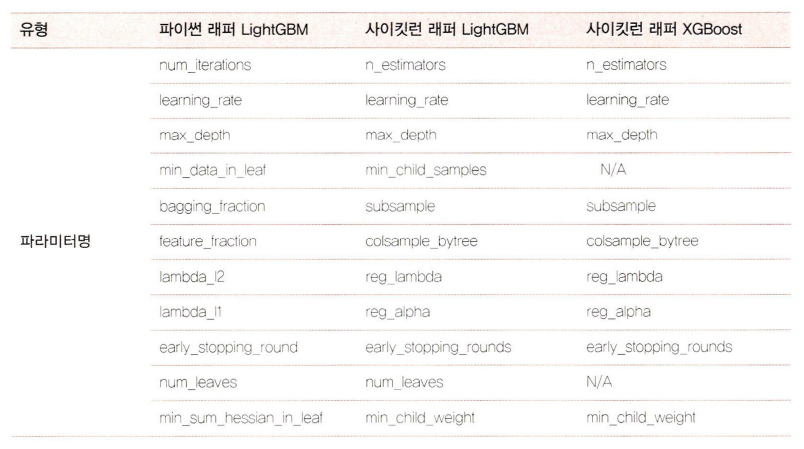

### [LightGBM 적용 - 위스콘신 유방암 예측]

In [45]:
#LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

#앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

#LightGMB도 XGBoost와 동일하게 조기 중단 수행 간으
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

In [46]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870, F1: 0.9682, AUC: 0.9905


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

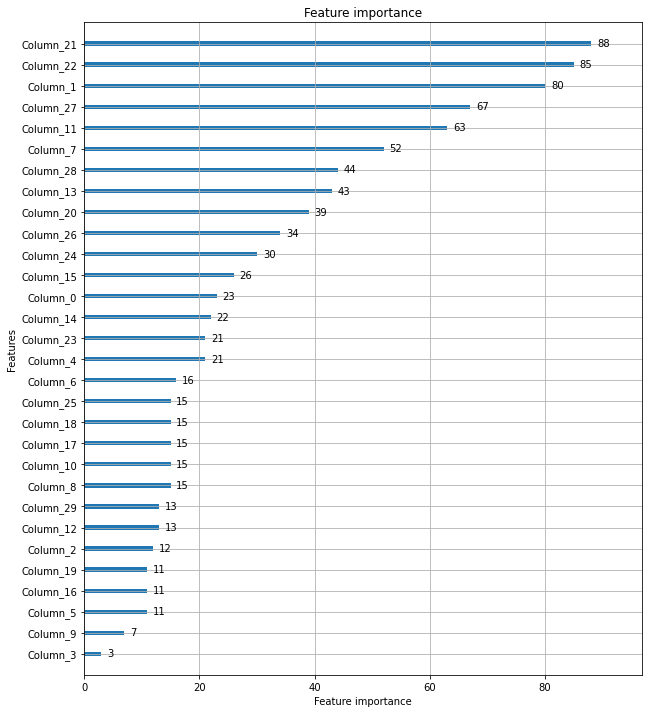

In [49]:
#plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

#lightgbm에 내장된 plot_importance() 역시 넘파이로 피처 데이터를 학습할 경우 피처명을 알 수 없기에
#Column_ 뒤에 피처 순서대로 숫자를 붙여서 X축에 나열함 (Column_0은 첫 번째 피처, Column_1은 두 번째 피처)

## 04-10 스태킹 앙상블 <br>
- 스태킹 (Stacking)은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 배깅 (Bagging) 및 부스팅 (Boosting)과 공통점을 가지고 있지만, 스태킹은 둘과 다르게 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행함
- 즉, 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식 <br><br>
- 스태킹 모델은 두 종류의 모델이 필요함
    - 개별적인 기반 모델
    - 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델
- 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것임
- 스태킹은 일반적으로 성능이 비슷한 모델을 결합해 좀 더 나은 성능 향상을 도출하기 위해 적용됨 <br>
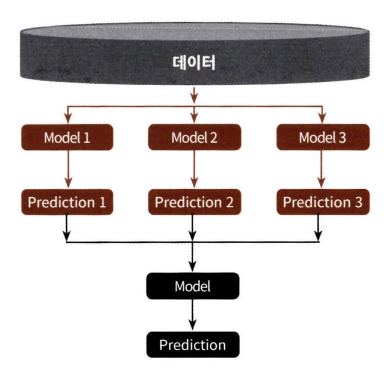 <br>
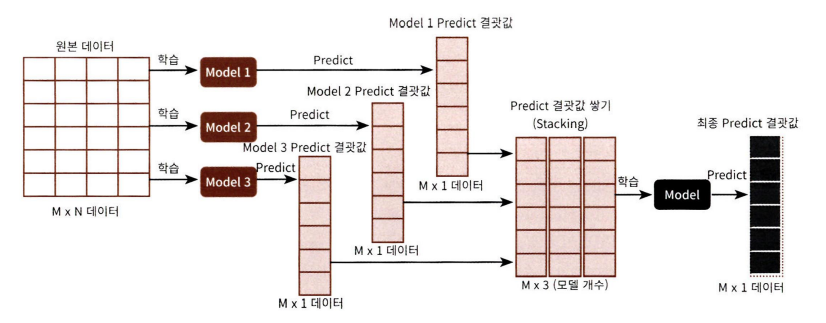

### [기본 스태킹 모델]

In [50]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [52]:
#개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

In [53]:
#개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [55]:
#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [57]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [59]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))
#개별 모델 정확도가 향상됨

최종 메타 모델의 예측 정확도: 0.9649


### [CV 세트 기반의 스태킹]
- 앞 예제에서 마지막에 메타 모델인 로지스틱 회귀 모델 기반에서 최종 학습할 때 레이블 데이터 세트로 학습 데이터가 아닌 테스트용 레이블 데이터 세트를 기반으로 학습했기에 과적합 문제가 발생할 수 있음
- CV 세트 기반의 스태킹은 이에 대한 개선을 위해 개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성과 예측을 위한 테스트용 스태킹 데이터를 생성한 뒤 이를 기반으로 메타 모델이 학습과 예측을 수행함
    - 스텝 1: 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성함
    - 스텝 2: 스텝 1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성함. 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트를 생성함. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가함 <br>
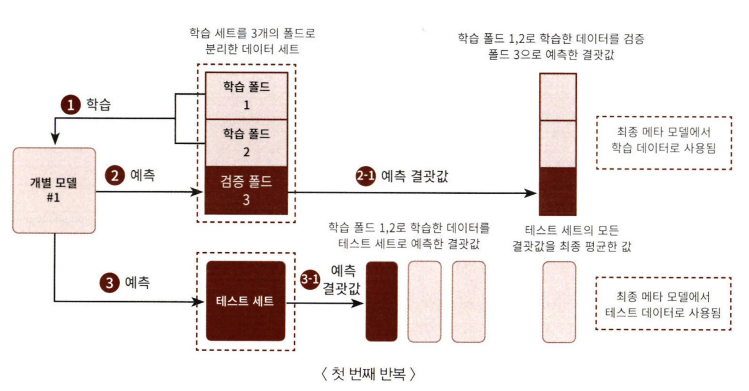 <br>
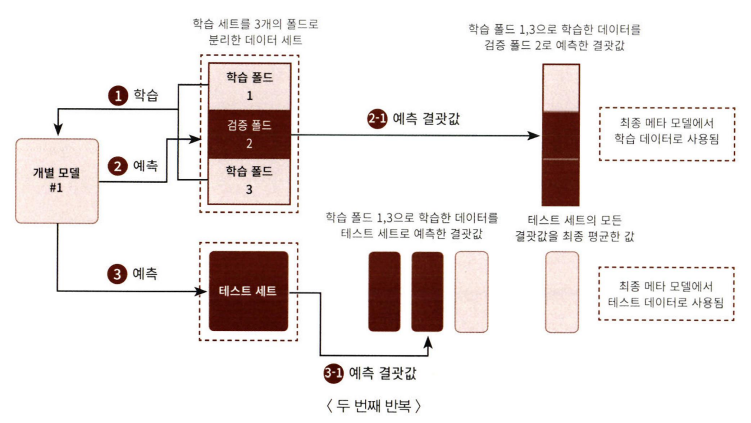 <br>
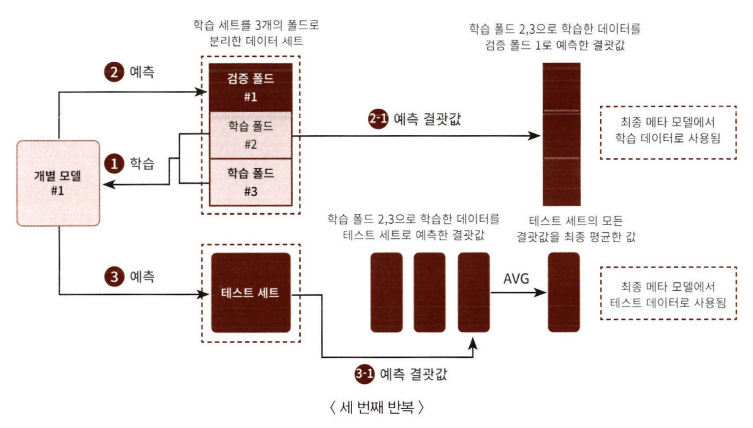 <br>
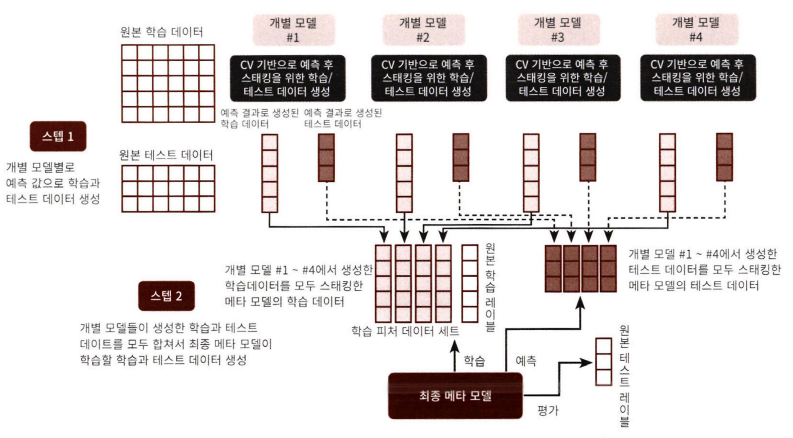

In [60]:
from sklearn.model_selection import KFold
from sklearn.metrics  import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    #지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [61]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작
RandomForestClassifier model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작
AdaBoostClassifier model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작


In [63]:
#Stack_final_X_train: 메타 모델이 학습할 학습용 피처 데이터 세트
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
#Stack_final_X_test: 메타 모델이 예측할 테스트용 피처 데이터 세트
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape, '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [64]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
